This notebook is an example of using the `residuated-binars` package for looking for finite models of lattices.

In [1]:
# First, let's prepare directories
import shutil
import os

def prepare_dirs() -> None:
    shutil.rmtree(os.path.join(".", "hyp"))
    shutil.rmtree(os.path.join(".", "task"))
    os.mkdir(os.path.join(".", "hyp"))
    os.mkdir(os.path.join(".", "task"))

    
prepare_dirs()

We use the `generate_isabelle_theory_file` function to write an [Isabelle](https://isabelle.in.tum.de/) theory file containing lattice axioms.

This function writes a file containing a single lemma. So, we pass all lattice axiom as the `assumptions` argument and the expression meaning that join and meet operations are the same as the `goal`. A counter-example for such a 'lemma' will be exactly something obeying all the lattice axioms (and with different operations for join and meet).

In [2]:
from residuated_binars.constants import LATTICE, FOR_X_Y
from residuated_binars.generate_theories import generate_isabelle_theory_file

with open(os.path.join("hyp", "Lattice.thy"), "w") as theory:
    theory.write(
        "\n".join(generate_isabelle_theory_file(
            theory_name="Lattice",
            assumptions=LATTICE,
            goal=f"({FOR_X_Y} meet(x, y) = join(x, y))"
        ))
    )
# notice the `oops` line. It means we provide no proof for our lemma
with open(os.path.join("hyp", "Lattice.thy"), "r") as a_file:
    print(a_file.read())

theory Lattice
imports Main
begin
lemma "(
(\<forall> x::nat. \<forall> y::nat. meet(x, y) = meet(y, x)) &
(\<forall> x::nat. \<forall> y::nat. join(x, y) = join(y, x)) &
(\<forall> x::nat. \<forall> y::nat. \<forall> z::nat. meet(x, meet(y, z)) = meet(meet(x, y), z)) &
(\<forall> x::nat. \<forall> y::nat. \<forall> z::nat. join(x, join(y, z)) = join(join(x, y), z)) &
(\<forall> x::nat. \<forall> y::nat. meet(x, join(x, y)) = x) &
(\<forall> x::nat. \<forall> y::nat. join(x, meet(x, y)) = x)
) \<longrightarrow>
(\<forall> x::nat. \<forall> y::nat. meet(x, y) = join(x, y))
"
oops
end


We need to add a task for Isabelle server to do something with our lemma. The `add_task` function supports two types of tasks:

* [sledgehammer](https://isabelle.in.tum.de/dist/Isabelle2021-1/doc/sledgehammer.pdf) --- apply Automated Theorem Provers to find proof for a lemma (not our case)
* [nitpick](https://isabelle.in.tum.de/dist/Isabelle2021-1/doc/nitpick.pdf) --- apply Satisfiability Modulo Theory solvers to find a counter-example for a lemma (that's what we want to do)

The function `add_task` works with a folder of theory files and adds the same task for every theory file in a directory. It doesn't touch original files but creates a new directory with modified ones.

In [3]:
from residuated_binars.add_task import add_task, TaskType

# we search a minimal non-trivial example of a lattice, of size two
add_task(
    source_path="hyp",
    target_path="task",
    task_type=TaskType.NITPICK,
    cardinality=2
)
# notice that since there was only one theory file in the `hyp` folder,
# there is only one in the `task` folder.
# there is only one theory file in the `task` folder too
print(os.listdir("hyp"))
with open(os.path.join("hyp", "Lattice.thy"), "r") as a_file:
    print(a_file.read())

['Lattice.thy']
theory Lattice
imports Main
begin
lemma "(
(\<forall> x::nat. \<forall> y::nat. meet(x, y) = meet(y, x)) &
(\<forall> x::nat. \<forall> y::nat. join(x, y) = join(y, x)) &
(\<forall> x::nat. \<forall> y::nat. \<forall> z::nat. meet(x, meet(y, z)) = meet(meet(x, y), z)) &
(\<forall> x::nat. \<forall> y::nat. \<forall> z::nat. join(x, join(y, z)) = join(join(x, y), z)) &
(\<forall> x::nat. \<forall> y::nat. meet(x, join(x, y)) = x) &
(\<forall> x::nat. \<forall> y::nat. join(x, meet(x, y)) = x)
) \<longrightarrow>
(\<forall> x::nat. \<forall> y::nat. meet(x, y) = join(x, y))
"
oops
end


We use [isabelle-client](https://pypi.org/project/isabelle-client/) to send our theory files to the Isabelle server. The function `check_assumptions` is a wrapper for it. The Isabelle server processes all the theory files from a folder in parallel.

In [4]:
from residuated_binars.check_assumptions import check_assumptions

# notice that after running this command
# there appears a new file `isabelle.out` in the `task` folder.
# It contains the log of communication to the Isabelle server
check_assumptions("task")
print(os.listdir("task"))

['Lattice.thy', 'isabelle.out']


`residuated-binars` provide a parser of Isabelle server logs for extracting models found by Nitpick. For now, it can parse models of lattices and residuated binars.

In [5]:
from residuated_binars.parser import isabelle_response_to_algebra

lattices = isabelle_response_to_algebra(
    os.path.join("task", "isabelle.out")
)

In [6]:
# we have only one model since we had only one theory file
lattices

[{'join': [[0, 0], [0, 1]], 'meet': [[0, 1], [1, 1]]}]

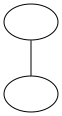

In [7]:
# we also can draw a Hasse diagram of the lattice
# to get more intuition about its structure
lattices[0].canonise_symbols()
lattices[0].graphviz_repr

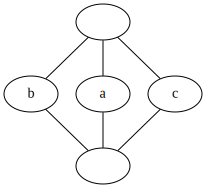

In [8]:
# here is an example of a lattice that is modular but not distributive
from residuated_binars.constants import RIGHT_DISTRIBUTIVITY, MODULARITY

prepare_dirs()
with open(os.path.join("hyp", "Lattice.thy"), "w") as theory:
    theory.write(
        "\n".join(generate_isabelle_theory_file(
            theory_name="Lattice",
            assumptions=LATTICE + [MODULARITY],
            goal=(
                RIGHT_DISTRIBUTIVITY
                .replace("f(", "meet(")
                .replace("g(", "join(")
            )
        ))
    )
add_task("hyp", "task", TaskType.NITPICK, 5)
check_assumptions("task")
lattices = isabelle_response_to_algebra(
    os.path.join("task", "isabelle.out")
)
lattices[0].canonise_symbols()
lattices[0].graphviz_repr

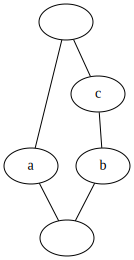

In [9]:
# and an example of a lattice that is not modular
prepare_dirs()
with open(os.path.join("hyp", "Lattice.thy"), "w") as theory:
    theory.write(
        "\n".join(generate_isabelle_theory_file(
            theory_name="Lattice",
            assumptions=LATTICE,
            goal=MODULARITY
        ))
    )
add_task("hyp", "task", TaskType.NITPICK, 5)
check_assumptions("task")
lattices = isabelle_response_to_algebra(
    os.path.join("task", "isabelle.out")
)
lattices[0].canonise_symbols()
lattices[0].graphviz_repr

In [10]:
# here is an example of automatic proof that
# every distributive lattice is also modular
prepare_dirs()
with open(os.path.join("hyp", "Lattice.thy"), "w") as theory:
    theory.write(
        "\n".join(generate_isabelle_theory_file(
            theory_name="Lattice",
            assumptions=LATTICE + [
                RIGHT_DISTRIBUTIVITY
                .replace("f(", "meet(")
                .replace("g(", "join(")
            ],
            goal=MODULARITY
        ))
    )
add_task("hyp", "task", TaskType.SLEDGEHAMMER)
check_assumptions("task")

In [11]:
import json

with open(os.path.join("task", "isabelle.out"), "r") as a_file:
    for line in a_file.readlines():
        if "Proof found" in line:
            print(json.loads(line[9:])["nodes"][0]["messages"][3]["message"])

"cvc4": Try this: by (smt (verit, del_insts)) (778 ms)
